# Trasformazioni gemoetriche

# Distorsioni causate da lenti: barile e cuscino
### Marco Zucca s4828628



# Introduzione

Quando viene scattata una fotografia il tipo di lente utilizzata per lo scatto deformerà in qualche modo il risultato creando degli effetti in cui l'immagine assume delle curve concave o convesse creando una distorsione detta a "barile" (barrel) e a "cuscino" (pincushion) rispettivamente.
Queste deformazioni non sono sempre dannose per l'immagine, possono essere utilizzate per creare affetti come il fish-eye(?)

# Obiettivi

- Riuscire a distorcere un'immagine con la distorsione a barile e cuscino
- Provare a correggere immagini deformate applicando la deformazione inversa

# Implementazione

### Librerie

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import data, io, color


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from PIL import Image, ImageDraw

### Funzioni di supporto
Per rendere il codice più leggibile, vengono utilizzate le seguenti funzioni di supporto per:
- convertire le coordinate cartesiane in coordinate polari per applicare la trasformazione
- ri convertire da coordinate polari a cartesiane per poter rappresentare l'immagine

In [2]:
#converte le coordinate cartesiane in polari
def cart2pol(x,y):
    theta = np.arctan2(y,x)
    rho = np.sqrt(x**2 + y**2)
    return (theta, rho)

In [3]:
#converte le coordinate polari in cartesiane
def pol2cart(theta,rho):
    x = rho*np.cos(theta)
    y = rho*np.sin(theta)
    return (x, y)

### Distorsione da un punto scelto
Prende un'immagine come input e applica la distorisone partendo dal punto definito da wpx e wpy con fattore di deformazione rf. Se viene inserito un valore negativo si crea una distorsione a barile, se positivo a cuscino


In [4]:
def lensDistorsion(image,wpx,wpy,scale,rf):
    width,height=image.shape[:2]
    print(width,height)
    if  (wpx > width or wpx < 0) or (wpy > height or wpy < 0):
        print("Punto non valido")
        return
    dst = np.zeros((width, height, 3), dtype=np.uint8)
    R = np.sqrt((width/2)**2 + (height/2)**2)

    for u in range(width):
        for v in range(height):
            
            x1 = u-wpx
            y1 = v-wpy
            
            x2 /= scale
            y2 /= scale
            
            #converte da cordinate cartesaine a polari
            theta,r = cart2pol(x2,y2)
            #normalizzazione
            r = r/R
            #modello
            s = r*(1 + rf*(r**2))
            #de-normalizza
            s2 = s*R
            #riconverte da cordiante poalri a cartesiane
            x4,y4 = pol2cart(theta,s2)
            #trasla al punto originario
            x = x3+wpx
            y = y3+wpy

            
            intx, inty = int(x), int(y)
            fracx, fracy = x%1, y%1
            if 0 < x < width-1 and 0 < y < height-1:
                dst[u, v] = fracx*fracy*image[intx, inty]+(1-fracx)*fracy*image[intx+1, inty]+fracx*(1-fracy)*image[intx, inty+1]+(1-fracx)*(1-fracy)*image[intx+1, inty+1]
    return dst

### Distorsione dal centro
Come la precedente ma il punto da cui parte la distorsione è il centro

In [5]:
def lensDistorsionCenter(image,scale,rf):
    width,height=image.shape[:2]
    dst = np.zeros((width, height, 3), dtype=np.uint8)
    R = np.sqrt((width/2)**2 + (height/2)**2)
    w2 = width/2
    h2 = height/2
    
    for u in range(width):
        for v in range(height):
            #trasla al centro
            x2 = u-w2
            y2 = v-h2
            #scala se necessario
            x2 /= scale
            y2 /= scale
            #converte da cordinate cartesaine a polari
            theta,r = cart2pol(x2,y2)
            #normalizzazione
            r = r/R
            #modello
            s = r*(1 + rf*(r**2))
            #de-normalizza
            s2 = s*R
            #riconverte da cordiante poalri a cartesiane
            x4,y4 = pol2cart(theta,s2)
            #traasla al punto originario
            x = x4+w2
            y = y4+h2
            
            intx, inty = int(x), int(y)
            fracx, fracy = x%1, y%1
            if 0 < x < width-1 and 0 < y < height-1:
                dst[u, v] = fracx*fracy*image[intx, inty]+(1-fracx)*fracy*image[intx+1, inty]+fracx*(1-fracy)*image[intx, inty+1]+(1-fracx)*(1-fracy)*image[intx+1, inty+1]
    return dst

Per applicare la trasformazione bisogna "spostarsi" dalle coordinate 0,0 al centro dell'immagine (o nel punto scelto), quindi si applica una traslazione all'inizio della funzione e alla fine prima di ritornarre il pixel corrispondente distorto. 

Dopo di che si puo' decidere se scalare l'immagine secono un certo valore preso come parametro, questa operazione puo' essere necesasria perchè applicando certe trasformazioni è possibile ottenere dei margini o effetti non voluti(come si vedrà in seguito).

Si converte da coordinate cartesiane a polari perchè è più naturale pensare in questi termini per implemetare la trasformazione: la traformazione è "concentrica" dal punto in cui inizia, ovvero, dal punto di partenza (come puo' essere il centro dell'immagine) si cambia mano a mano la distanza da esso a seconda del parametro, quindi si cambia il valore di rho (modulo) ed a ogni iterazione si cambia il valore di theta (fase), rho rappresenta anche la distanza tra il punto dell'immagine distorta e il punto di distorisione, necessaria per applicare il modello.

Prima di applicare il modello vero e proprio si normalizza moltilpicando il modulo ottenuto con la la distanza dal centro dell'immagine.

Il modello applicato è una semplificazione della formula della "radial distorsion" in cui viene utilizzato solo un parametro (rf) per calcolare la distorsione. In teoria la formula accetta un numero indefinito di parametri per raggiungere una precisone sempre maggiore e ricostruire l'immagine in modo più fedele, ma per i nostri scopi (ed in generale nella maggior parte dei casi) un solo parametro è sufficiente.

Prima di applicare il mapping inverso per costruire l'immagine distorta, bisogna de-normalizzare l'immagine e ri-traslare il punto dal centro a dove si trovava in origine.

todo

# Analisi sperimentali

### Immagini test

In questa prima parte verranno utilizzate immagini con griglie e linee per poter notare al meglio le trasformazioni applicate e il loro risultato.
Prima di tutto si prova a distorcere un'immagine "normale" per osservare il risultato dopo la distorsione, si applica lo stesso fattore di distorsione ma con segno opposto:

In [6]:
img = io.imread('test_grid.jpg')
target = io.imread('target.jpg')

[<PIL.Image.Image image mode=RGB size=500x500 at 0x7F317A1118D0>, <PIL.Image.Image image mode=RGB size=500x500 at 0x7F317A1117E0>, <PIL.Image.Image image mode=RGB size=500x500 at 0x7F317A111900>, <PIL.Image.Image image mode=RGB size=500x500 at 0x7F317A111870>, <PIL.Image.Image image mode=RGB size=500x500 at 0x7F317A111840>]


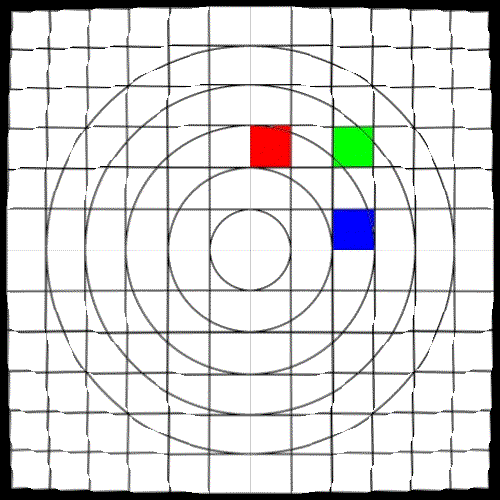

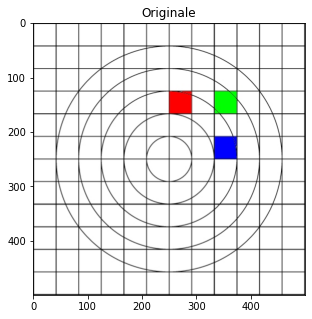

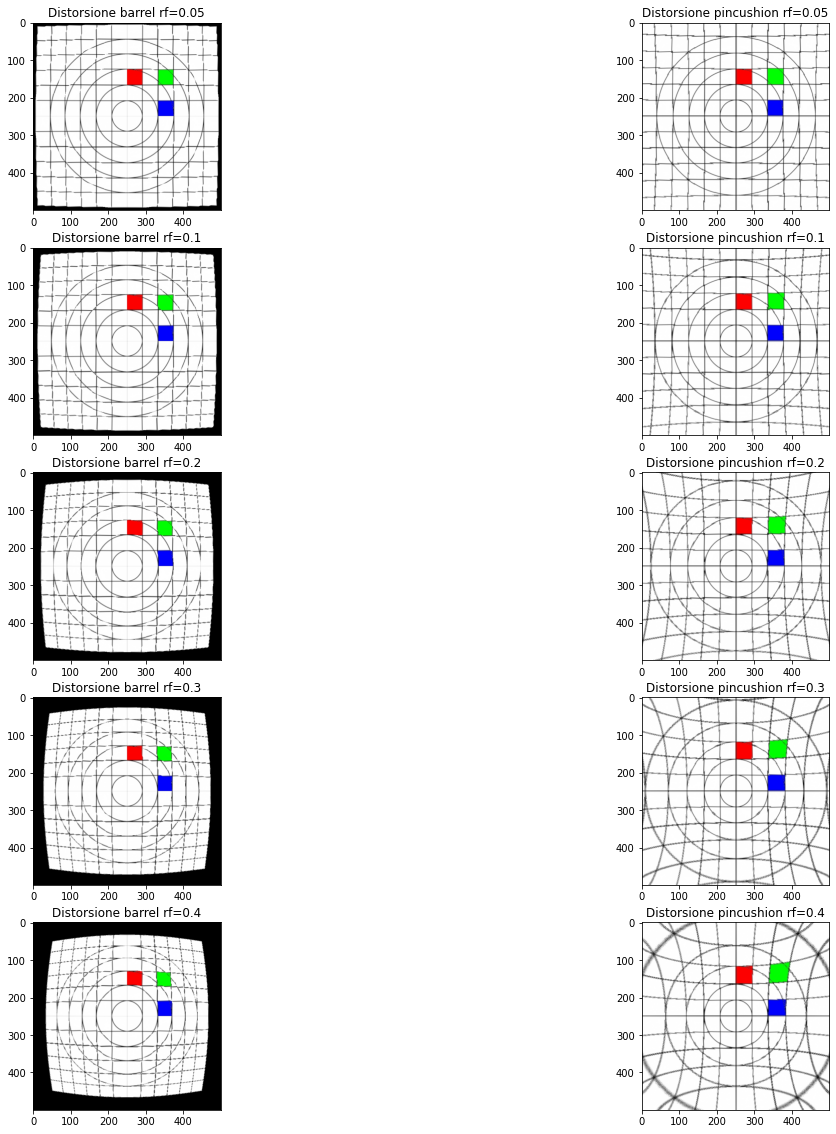

In [12]:
gifBarrel = []

imgBarrel05 = lensDistorsionCenter(img,1,+0.05)
gifBarrel.append(Image.fromarray(imgBarrel05))
imgPin05 = lensDistorsionCenter(img,1,-0.05)

imgBarrel1 = lensDistorsionCenter(img,1,+0.1)
gifBarrel.append(Image.fromarray(imgBarrel1))
imgPin1 = lensDistorsionCenter(img,1,-0.1)

imgBarrel2 = lensDistorsionCenter(img,1,+0.2)
gifBarrel.append(Image.fromarray(imgBarrel2))
imgPin2 = lensDistorsionCenter(img,1,-0.2)

imgBarrel3 = lensDistorsionCenter(img,1,+0.3)
gifBarrel.append(Image.fromarray(imgBarrel3))
imgPin3 = lensDistorsionCenter(img,1,-0.3)

imgBarrel4 = lensDistorsionCenter(img,1,+0.4)
gifBarrel.append(Image.fromarray(imgBarrel4))
imgPin4 = lensDistorsionCenter(img,1,-0.4)



plt.figure(figsize=(5,5))
plt.subplot(1,1,1)
plt.title("Originale")
plt.imshow(img)

plt.figure(figsize=(20,20))

plt.subplot(5,2,1)
plt.title("Distorsione barrel rf=0.05")
plt.imshow(imgBarrel05)

plt.subplot(5,2,2)
plt.title("Distorsione pincushion rf=0.05")
plt.imshow(imgPin05)

plt.subplot(5,2,3)
plt.title("Distorsione barrel rf=0.1")
plt.imshow(imgBarrel1)

plt.subplot(5,2,4)
plt.title("Distorsione pincushion rf=0.1")
plt.imshow(imgPin1)

plt.subplot(5,2,5)
plt.title("Distorsione barrel rf=0.2")
plt.imshow(imgBarrel2)

plt.subplot(5,2,6)
plt.title("Distorsione pincushion rf=0.2")
plt.imshow(imgPin2)

plt.subplot(5,2,7)
plt.title("Distorsione barrel rf=0.3")
plt.imshow(imgBarrel3)

plt.subplot(5,2,8)
plt.title("Distorsione pincushion rf=0.3")
plt.imshow(imgPin3)

plt.subplot(5,2,9)
plt.title("Distorsione barrel rf=0.4")
plt.imshow(imgBarrel4)

plt.subplot(5,2,10)
plt.title("Distorsione pincushion rf=0.4")
plt.imshow(imgPin4)

print(gifBarrel)

togif = gifBarrel[0]
togif.save(fp='pillow_imagedraw.gif',
            format='GIF', append_images=gifBarrel,
            save_all=True, duration=200, loop=0)

In [ ]:
imgBarrel05f = lensDistorsionCenter(imgPin05,1,+0.05)
imgPin05f = lensDistorsionCenter(imgBarrel05,1,-0.05)

imgBarrel1f = lensDistorsionCenter(imgPin1,1,+0.1)
imgPin1f = lensDistorsionCenter(imgBarrel1,1,-0.1)

imgBarrel2f = lensDistorsionCenter(imgPin2,1,+0.2)
imgPin2f = lensDistorsionCenter(imgBarrel2,1,-0.2)

imgBarrel3f = lensDistorsionCenter(imgPin3,1,+0.3)
imgPin3f = lensDistorsionCenter(imgBarrel3,1,-0.3)

imgBarrel4f = lensDistorsionCenter(imgPin4,1,+0.4)
imgPin4f = lensDistorsionCenter(imgBarrel4,1,-0.4)

plt.figure(figsize=(5,5))
plt.subplot(1,1,1)
plt.title("Originale")
plt.imshow(img)

plt.figure(figsize=(20,20))

plt.subplot(5,2,1)
plt.title("Distorsione barrel rf=0.05")
plt.imshow(imgBarrel05f)

plt.subplot(5,2,2)
plt.title("Distorsione pincushion rf=0.05")
plt.imshow(imgPin05f)

plt.subplot(5,2,3)
plt.title("Distorsione barrel rf=0.1")
plt.imshow(imgBarrel1f)

plt.subplot(5,2,4)
plt.title("Distorsione pincushion rf=0.1")
plt.imshow(imgPin1f)

plt.subplot(5,2,5)
plt.title("Distorsione barrel rf=0.2")
plt.imshow(imgBarrel2f)

plt.subplot(5,2,6)
plt.title("Distorsione pincushion rf=0.2")
plt.imshow(imgPin2f)

plt.subplot(5,2,7)
plt.title("Distorsione barrel rf=0.3")
plt.imshow(imgBarrel3f)

plt.subplot(5,2,8)
plt.title("Distorsione pincushion rf=0.3")
plt.imshow(imgPin3f)

plt.subplot(5,2,9)
plt.title("Distorsione barrel rf=0.4")
plt.imshow(imgBarrel4f)

plt.subplot(5,2,10)
plt.title("Distorsione pincushion rf=0.4")
plt.imshow(imgPin4f)

TODO: considerazioni

### Volti

Si prova ora a correggere immagini reali già distorte in partenza (è stato utilizzato GIMP per applicare la deformazione) applicando la distorsione opposta.

Per ottenere una distorsione a cuscino "evidente", si è dovuta diminuire la dimensione (de-zoommare) dell'immagine, questo porta ad un'abbassamento della qualità quando si cercherà di correggerla.

In [ ]:
original = io.imread('turing.jpg')
pin = io.imread('turing_pincushion.jpg')
barrel = io.imread('turing_barrel.jpg')
 #giuste
pinCorrection = lensDistorsionCenter(pin,2.1,+1.6)
barrelCorrection = lensDistorsionCenter(barrel,1,-0.3)

pin1 = lensDistorsionCenter(pin,1.5,+0.1)
barrel1 = lensDistorsionCenter(barrel,1,-0.1)

pin2 = lensDistorsionCenter(pin,1.5,+0.2)
barrel2 = lensDistorsionCenter(barrel,1,-0.2)

pin3 = lensDistorsionCenter(pin,1.5,+0.3)
barrel3 = lensDistorsionCenter(barrel,1,-0.3)

pin4 = lensDistorsionCenter(pin,1.5,+0.4)
barrel4 = lensDistorsionCenter(barrel,1,-0.4)

pin5 = lensDistorsionCenter(pin,1.5,+0.5)
barrel5 = lensDistorsionCenter(barrel,1,-0.5)

pin6 = lensDistorsionCenter(pin,1.5,+1)
barrel6 = lensDistorsionCenter(barrel,1,-1)

pin7 = lensDistorsionCenter(pin,1.5,+1.5)
barrel7 = lensDistorsionCenter(barrel,1,-1.5)

#-----------------------------------------------#

#plt.figure(figsize=(10,10))
plt.imshow(original)

plt.figure(figsize=(40,40))
plt.subplot(7,2,1)
plt.title("Distorsione barrel rf=0.1")
plt.imshow(barrel1)

plt.subplot(7,2,2)
plt.title("Distorsione pincushion rf=0.1")
plt.imshow(pin1)

plt.subplot(7,2,3)
plt.title("Distorsione barrel rf=0.2")
plt.imshow(barrel2)

plt.subplot(7,2,4)
plt.title("Distorsione pincushion rf=0.2")
plt.imshow(pin2)

plt.subplot(7,2,5)
plt.title("Distorsione barrel rf=0.3")
plt.imshow(barrel3)

plt.subplot(7,2,6)
plt.title("Distorsione pincushion rf=0.3")
plt.imshow(pin3)

plt.subplot(7,2,7)
plt.title("Distorsione barrel rf=0.4")
plt.imshow(barrel4)

plt.subplot(7,2,8)
plt.title("Distorsione pincushion rf=0.4")
plt.imshow(pin4)

plt.subplot(7,2,9)
plt.title("Distorsione barrel rf=0.5")
plt.imshow(barrel5)

plt.subplot(7,2,10)
plt.title("Distorsione pincushion rf=0.5")
plt.imshow(pin5)

plt.subplot(7,2,11)
plt.title("Distorsione barrel rf=1")
plt.imshow(barrel6)

plt.subplot(7,2,12)
plt.title("Distorsione pincushion rf=1")
plt.imshow(pin6)

plt.subplot(7,2,13)
plt.title("Distorsione barrel rf=1.5")
plt.imshow(barrel7)

plt.subplot(7,2,14)
plt.title("Distorsione pincushion rf=1.5")
plt.imshow(pin7)

Si nota, per l'immagine con distorsione barrel, come con un fattore di distorsione pari a -0.3 si ottiene un'immagine simile a quella originale  , mentre per l'immagine con distorsione pincushion, serve un fattore di circa 1.5. 

Questa differenza puo' essere data dala fatto che l'immagine distorta a pincushion abbia una risoluzione più bassa.

# Conclusione

!!!

# Fonti
- https://www.mathworks.com/matlabcentral/fileexchange/37980-barrel-and-pincushion-lens-distortion-correction

- https://en.wikipedia.org/wiki/Distortion_(optics)

- https://stackoverflow.com/questions/6199636/formulas-for-barrel-pincushion-distortion (il link al paper originale è rotto, ma nel post viene usato un frammento del paper)

- http://www.paulbourke.net/miscellaneous/imagewarp/
    
